# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import helper
import problem_unittests as tests

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [2]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne 

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of each sentence from `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [66]:
import re
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    def process_target_text(text):
        """Helper function for processing  target text."""
        for sentence in text.lower().split('\n'): # +' <EOS>'): # .replace('.\n', '. <EOS>\n').split('\n'):
            yield [target_vocab_to_int[word] for word in  sentence.strip().split()] + [target_vocab_to_int['<EOS>']]
    
    def process_source_text(text):
        """Helper function for processing source text."""
        for sentence in text.lower().split('\n'):
            yield [source_vocab_to_int[word] for word in sentence.strip().split()]
        
    return list(process_source_text(source_text)), list(process_target_text(target_text))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
# assert LooseVersion(tf.__version__) in [LooseVersion('1.0.0'), LooseVersion('1.0.1')], 'This project requires TensorFlow version 1.0  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.

Return the placeholders in the following the tuple (Input, Targets, Learing Rate, Keep Probability)

In [70]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate, keep probability)
    """
    inputs = tf.placeholder(tf.int32, (None, None), name='input')
    targets = tf.placeholder(tf.int32, (None, None), name='target')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_probability = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs, targets, learning_rate, keep_probability

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoding Input
Implement `process_decoding_input` using TensorFlow to remove the last word id from each batch in `target_data` and concat the GO ID to the beginning of each batch.

In [91]:
def process_decoding_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for decoding
    :param target_data: Target Placeholder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    go_id = target_vocab_to_int['<GO>']
    #  np.concatenate((go_id*np.ones(batch_size).reshape(-1,1), np.array(test_target_data)[:,1:]), axis=1) # numpy
    # return tf.concat((go_id*np.ones(batch_size).reshape(-1,1), target_data[:, 1:]), axis=1)
    return tf.concat([ tf.fill([batch_size, 1], go_id), tf.strided_slice(
        target_data, [0, 0], [batch_size, -1], [1, 1])], 1)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_decoding_input(process_decoding_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer using [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

In [92]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :return: RNN state
    """
    enc_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)] * num_layers)
    # tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(rnn_size), output_keep_prob=keep_prob)] * num_layers)
    _, enc_state = tf.nn.dynamic_rnn(enc_cell, rnn_inputs, dtype=tf.float32)
    return enc_state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create training logits using [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder).  Apply the `output_fn` to the [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) outputs.

In [94]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param sequence_length: Sequence Length
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Train Logits
    """
    dynamic_fn_train = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    outputs_train, state_train, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, 
                                                                           dynamic_fn_train,
                                                                           dec_embed_input,
                                                                           sequence_length, 
                                                                           scope=decoding_scope)
    return tf.nn.dropout(output_fn(outputs_train), keep_prob)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference logits using [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder). 

In [95]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param maximum_length: The maximum allowed time steps to decode
    :param vocab_size: Size of vocabulary
    :param decoding_scope: TensorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Inference Logits
    """
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(output_fn, encoder_state, dec_embeddings,
                                                                    start_of_sequence_id, end_of_sequence_id,
                                                                    maximum_length, vocab_size)
    inference_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, infer_decoder_fn,
                                                                    scope=decoding_scope)
    inference_logits = tf.nn.dropout(inference_logits, keep_prob)
    return inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

- Create RNN cell for decoding using `rnn_size` and `num_layers`.
- Create the output fuction using [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to transform it's input, logits, to class logits.
- Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` function to get the training logits.
- Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [136]:
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, target_vocab_to_int, keep_prob):
    """
    Create decoding layer
    :param dec_embed_input: Decoder embedded input
    :param dec_embeddings: Decoder embeddings
    :param encoder_state: The encoded state
    :param vocab_size: Size of vocabulary
    :param sequence_length: Sequence Length
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param keep_prob: Dropout keep probability
    :return: Tuple of (Training Logits, Inference Logits)
    """
    dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)]*num_layers)
    
    with tf.variable_scope("decoding") as decoding_scope:
        
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
        train_logits = decoding_layer_train(encoder_state, dec_cell, dec_embed_input,
                                            sequence_length, decoding_scope, output_fn, keep_prob)
        decoding_scope.reuse_variables()
        inference_logits = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings,
                                                target_vocab_to_int['<GO>'], target_vocab_to_int['<EOS>'],
                                                sequence_length, vocab_size,
                                                decoding_scope, output_fn, keep_prob)
        return train_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Apply embedding to the input data for the encoder.
- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)`.
- Process target data using your `process_decoding_input(target_data, target_vocab_to_int, batch_size)` function.
- Apply embedding to the target data for the decoder.
- Decode the encoded input using your `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)`.

In [137]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param sequence_length: Sequence Length
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training Logits, Inference Logits)
    """
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, enc_embedding_size)
    enc_state = encoding_layer(enc_embed_input, rnn_size, num_layers, keep_prob)
    processed_target_data = process_decoding_input(target_data, target_vocab_to_int, batch_size)

    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, dec_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, processed_target_data)
    
    return  decoding_layer(dec_embed_input, dec_embeddings, enc_state, target_vocab_size, sequence_length, rnn_size,
                    num_layers, target_vocab_to_int, keep_prob)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability

In [138]:
len(source_vocab_to_int), len(target_vocab_to_int)

(231, 358)

In [157]:
# Number of Epochs
epochs = 10
# Batch Size
batch_size = 1024
# RNN Size
rnn_size = 128
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 64
decoding_embedding_size = 64
# Learning Rate
learning_rate = 0.003
# Dropout Keep Probability
keep_probability = 0.6

### Build the Graph
Build the graph using the neural network you implemented.

In [158]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = seq2seq_model(
        tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
        encoding_embedding_size, decoding_embedding_size, rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forums to see if anyone is having the same problem.

In [159]:
train_valid_accs = []

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import time

def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1]), (0,0)],
            'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = helper.pad_sentence_batch(source_int_text[:batch_size])
valid_target = helper.pad_sentence_batch(target_int_text[:batch_size])

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch) in enumerate(
                helper.batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 sequence_length: target_batch.shape[1],
                 keep_prob: keep_probability})
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)

            train_valid_accs.append((train_acc, valid_acc, loss))
            end_time = time.time()
            print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.3f}, Validation Accuracy: {:>6.3f}, Loss: {:>6.3f}'
                  .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

items nbr: 136837 Batches: 133
Epoch   0 Batch    0/134 - Train Accuracy:  0.267, Validation Accuracy:  0.310, Loss:  5.895
Epoch   0 Batch    1/134 - Train Accuracy:  0.238, Validation Accuracy:  0.310, Loss:  5.569
Epoch   0 Batch    2/134 - Train Accuracy:  0.281, Validation Accuracy:  0.318, Loss:  5.081
Epoch   0 Batch    3/134 - Train Accuracy:  0.301, Validation Accuracy:  0.333, Loss:  4.844
Epoch   0 Batch    4/134 - Train Accuracy:  0.302, Validation Accuracy:  0.341, Loss:  4.751
Epoch   0 Batch    5/134 - Train Accuracy:  0.323, Validation Accuracy:  0.354, Loss:  4.542
Epoch   0 Batch    6/134 - Train Accuracy:  0.340, Validation Accuracy:  0.343, Loss:  4.462
Epoch   0 Batch    7/134 - Train Accuracy:  0.304, Validation Accuracy:  0.343, Loss:  4.454
Epoch   0 Batch    8/134 - Train Accuracy:  0.304, Validation Accuracy:  0.343, Loss:  4.363
Epoch   0 Batch    9/134 - Train Accuracy:  0.341, Validation Accuracy:  0.343, Loss:  4.257
Epoch   0 Batch   10/134 - Train Accura

Epoch   0 Batch   88/134 - Train Accuracy:  0.484, Validation Accuracy:  0.488, Loss:  3.216
Epoch   0 Batch   89/134 - Train Accuracy:  0.459, Validation Accuracy:  0.487, Loss:  3.259
Epoch   0 Batch   90/134 - Train Accuracy:  0.448, Validation Accuracy:  0.479, Loss:  3.259
Epoch   0 Batch   91/134 - Train Accuracy:  0.516, Validation Accuracy:  0.474, Loss:  3.075
Epoch   0 Batch   92/134 - Train Accuracy:  0.460, Validation Accuracy:  0.484, Loss:  3.230
Epoch   0 Batch   93/134 - Train Accuracy:  0.475, Validation Accuracy:  0.486, Loss:  3.198
Epoch   0 Batch   94/134 - Train Accuracy:  0.447, Validation Accuracy:  0.471, Loss:  3.188
Epoch   0 Batch   95/134 - Train Accuracy:  0.431, Validation Accuracy:  0.459, Loss:  3.206
Epoch   0 Batch   96/134 - Train Accuracy:  0.448, Validation Accuracy:  0.479, Loss:  3.202
Epoch   0 Batch   97/134 - Train Accuracy:  0.453, Validation Accuracy:  0.489, Loss:  3.195
Epoch   0 Batch   98/134 - Train Accuracy:  0.412, Validation Accuracy

Epoch   1 Batch   43/134 - Train Accuracy:  0.515, Validation Accuracy:  0.547, Loss:  2.669
Epoch   1 Batch   44/134 - Train Accuracy:  0.515, Validation Accuracy:  0.541, Loss:  2.642
Epoch   1 Batch   45/134 - Train Accuracy:  0.517, Validation Accuracy:  0.550, Loss:  2.650
Epoch   1 Batch   46/134 - Train Accuracy:  0.546, Validation Accuracy:  0.551, Loss:  2.637
Epoch   1 Batch   47/134 - Train Accuracy:  0.537, Validation Accuracy:  0.552, Loss:  2.643
Epoch   1 Batch   48/134 - Train Accuracy:  0.532, Validation Accuracy:  0.547, Loss:  2.655
Epoch   1 Batch   49/134 - Train Accuracy:  0.526, Validation Accuracy:  0.548, Loss:  2.647
Epoch   1 Batch   50/134 - Train Accuracy:  0.525, Validation Accuracy:  0.553, Loss:  2.673
Epoch   1 Batch   51/134 - Train Accuracy:  0.482, Validation Accuracy:  0.498, Loss:  2.640
Epoch   1 Batch   52/134 - Train Accuracy:  0.516, Validation Accuracy:  0.539, Loss:  2.703
Epoch   1 Batch   53/134 - Train Accuracy:  0.508, Validation Accuracy

Epoch   1 Batch  132/134 - Train Accuracy:  0.596, Validation Accuracy:  0.603, Loss:  2.503
items nbr: 136837 Batches: 133
Epoch   2 Batch    0/134 - Train Accuracy:  0.576, Validation Accuracy:  0.598, Loss:  2.514
Epoch   2 Batch    1/134 - Train Accuracy:  0.579, Validation Accuracy:  0.594, Loss:  2.530
Epoch   2 Batch    2/134 - Train Accuracy:  0.589, Validation Accuracy:  0.598, Loss:  2.477
Epoch   2 Batch    3/134 - Train Accuracy:  0.588, Validation Accuracy:  0.596, Loss:  2.534
Epoch   2 Batch    4/134 - Train Accuracy:  0.587, Validation Accuracy:  0.596, Loss:  2.489
Epoch   2 Batch    5/134 - Train Accuracy:  0.596, Validation Accuracy:  0.612, Loss:  2.525
Epoch   2 Batch    6/134 - Train Accuracy:  0.614, Validation Accuracy:  0.604, Loss:  2.506
Epoch   2 Batch    7/134 - Train Accuracy:  0.582, Validation Accuracy:  0.594, Loss:  2.519
Epoch   2 Batch    8/134 - Train Accuracy:  0.590, Validation Accuracy:  0.598, Loss:  2.501
Epoch   2 Batch    9/134 - Train Accura

Epoch   2 Batch   87/134 - Train Accuracy:  0.605, Validation Accuracy:  0.616, Loss:  2.466
Epoch   2 Batch   88/134 - Train Accuracy:  0.628, Validation Accuracy:  0.627, Loss:  2.463
Epoch   2 Batch   89/134 - Train Accuracy:  0.596, Validation Accuracy:  0.608, Loss:  2.498
Epoch   2 Batch   90/134 - Train Accuracy:  0.603, Validation Accuracy:  0.610, Loss:  2.446
Epoch   2 Batch   91/134 - Train Accuracy:  0.667, Validation Accuracy:  0.626, Loss:  2.410
Epoch   2 Batch   92/134 - Train Accuracy:  0.621, Validation Accuracy:  0.634, Loss:  2.469
Epoch   2 Batch   93/134 - Train Accuracy:  0.620, Validation Accuracy:  0.633, Loss:  2.445
Epoch   2 Batch   94/134 - Train Accuracy:  0.618, Validation Accuracy:  0.629, Loss:  2.451
Epoch   2 Batch   95/134 - Train Accuracy:  0.620, Validation Accuracy:  0.630, Loss:  2.450
Epoch   2 Batch   96/134 - Train Accuracy:  0.618, Validation Accuracy:  0.631, Loss:  2.443
Epoch   2 Batch   97/134 - Train Accuracy:  0.611, Validation Accuracy

Epoch   3 Batch   42/134 - Train Accuracy:  0.660, Validation Accuracy:  0.675, Loss:  2.367
Epoch   3 Batch   43/134 - Train Accuracy:  0.664, Validation Accuracy:  0.674, Loss:  2.376
Epoch   3 Batch   44/134 - Train Accuracy:  0.662, Validation Accuracy:  0.681, Loss:  2.369
Epoch   3 Batch   45/134 - Train Accuracy:  0.669, Validation Accuracy:  0.673, Loss:  2.362
Epoch   3 Batch   46/134 - Train Accuracy:  0.673, Validation Accuracy:  0.675, Loss:  2.352
Epoch   3 Batch   47/134 - Train Accuracy:  0.662, Validation Accuracy:  0.673, Loss:  2.388
Epoch   3 Batch   48/134 - Train Accuracy:  0.665, Validation Accuracy:  0.677, Loss:  2.373
Epoch   3 Batch   49/134 - Train Accuracy:  0.681, Validation Accuracy:  0.686, Loss:  2.376
Epoch   3 Batch   50/134 - Train Accuracy:  0.651, Validation Accuracy:  0.675, Loss:  2.363
Epoch   3 Batch   51/134 - Train Accuracy:  0.652, Validation Accuracy:  0.677, Loss:  2.375
Epoch   3 Batch   52/134 - Train Accuracy:  0.656, Validation Accuracy

Epoch   3 Batch  131/134 - Train Accuracy:  0.688, Validation Accuracy:  0.701, Loss:  2.332
Epoch   3 Batch  132/134 - Train Accuracy:  0.699, Validation Accuracy:  0.707, Loss:  2.316
items nbr: 136837 Batches: 133
Epoch   4 Batch    0/134 - Train Accuracy:  0.699, Validation Accuracy:  0.706, Loss:  2.341
Epoch   4 Batch    1/134 - Train Accuracy:  0.673, Validation Accuracy:  0.700, Loss:  2.350
Epoch   4 Batch    2/134 - Train Accuracy:  0.685, Validation Accuracy:  0.706, Loss:  2.299
Epoch   4 Batch    3/134 - Train Accuracy:  0.692, Validation Accuracy:  0.699, Loss:  2.304
Epoch   4 Batch    4/134 - Train Accuracy:  0.685, Validation Accuracy:  0.705, Loss:  2.314
Epoch   4 Batch    5/134 - Train Accuracy:  0.697, Validation Accuracy:  0.706, Loss:  2.318
Epoch   4 Batch    6/134 - Train Accuracy:  0.708, Validation Accuracy:  0.715, Loss:  2.314
Epoch   4 Batch    7/134 - Train Accuracy:  0.690, Validation Accuracy:  0.706, Loss:  2.320
Epoch   4 Batch    8/134 - Train Accura

Epoch   4 Batch   86/134 - Train Accuracy:  0.747, Validation Accuracy:  0.748, Loss:  2.236
Epoch   4 Batch   87/134 - Train Accuracy:  0.743, Validation Accuracy:  0.750, Loss:  2.248
Epoch   4 Batch   88/134 - Train Accuracy:  0.761, Validation Accuracy:  0.761, Loss:  2.207
Epoch   4 Batch   89/134 - Train Accuracy:  0.720, Validation Accuracy:  0.739, Loss:  2.234
Epoch   4 Batch   90/134 - Train Accuracy:  0.733, Validation Accuracy:  0.753, Loss:  2.257
Epoch   4 Batch   91/134 - Train Accuracy:  0.782, Validation Accuracy:  0.764, Loss:  2.227
Epoch   4 Batch   92/134 - Train Accuracy:  0.760, Validation Accuracy:  0.758, Loss:  2.250
Epoch   4 Batch   93/134 - Train Accuracy:  0.757, Validation Accuracy:  0.753, Loss:  2.245
Epoch   4 Batch   94/134 - Train Accuracy:  0.764, Validation Accuracy:  0.764, Loss:  2.234
Epoch   4 Batch   95/134 - Train Accuracy:  0.757, Validation Accuracy:  0.771, Loss:  2.238
Epoch   4 Batch   96/134 - Train Accuracy:  0.759, Validation Accuracy

Epoch   5 Batch   41/134 - Train Accuracy:  0.805, Validation Accuracy:  0.813, Loss:  2.194
Epoch   5 Batch   42/134 - Train Accuracy:  0.812, Validation Accuracy:  0.818, Loss:  2.186
Epoch   5 Batch   43/134 - Train Accuracy:  0.808, Validation Accuracy:  0.821, Loss:  2.160
Epoch   5 Batch   44/134 - Train Accuracy:  0.801, Validation Accuracy:  0.815, Loss:  2.228
Epoch   5 Batch   45/134 - Train Accuracy:  0.827, Validation Accuracy:  0.821, Loss:  2.183
Epoch   5 Batch   46/134 - Train Accuracy:  0.823, Validation Accuracy:  0.819, Loss:  2.171
Epoch   5 Batch   47/134 - Train Accuracy:  0.805, Validation Accuracy:  0.814, Loss:  2.175
Epoch   5 Batch   48/134 - Train Accuracy:  0.830, Validation Accuracy:  0.826, Loss:  2.175
Epoch   5 Batch   49/134 - Train Accuracy:  0.806, Validation Accuracy:  0.814, Loss:  2.127
Epoch   5 Batch   50/134 - Train Accuracy:  0.813, Validation Accuracy:  0.828, Loss:  2.186
Epoch   5 Batch   51/134 - Train Accuracy:  0.801, Validation Accuracy

Epoch   5 Batch  130/134 - Train Accuracy:  0.860, Validation Accuracy:  0.866, Loss:  2.170
Epoch   5 Batch  131/134 - Train Accuracy:  0.850, Validation Accuracy:  0.864, Loss:  2.168
Epoch   5 Batch  132/134 - Train Accuracy:  0.871, Validation Accuracy:  0.866, Loss:  2.152
items nbr: 136837 Batches: 133
Epoch   6 Batch    0/134 - Train Accuracy:  0.866, Validation Accuracy:  0.858, Loss:  2.138
Epoch   6 Batch    1/134 - Train Accuracy:  0.848, Validation Accuracy:  0.858, Loss:  2.161
Epoch   6 Batch    2/134 - Train Accuracy:  0.860, Validation Accuracy:  0.860, Loss:  2.125
Epoch   6 Batch    3/134 - Train Accuracy:  0.875, Validation Accuracy:  0.871, Loss:  2.095
Epoch   6 Batch    4/134 - Train Accuracy:  0.856, Validation Accuracy:  0.866, Loss:  2.147
Epoch   6 Batch    5/134 - Train Accuracy:  0.869, Validation Accuracy:  0.870, Loss:  2.128
Epoch   6 Batch    6/134 - Train Accuracy:  0.867, Validation Accuracy:  0.865, Loss:  2.143
Epoch   6 Batch    7/134 - Train Accura

Epoch   6 Batch   85/134 - Train Accuracy:  0.893, Validation Accuracy:  0.893, Loss:  2.117
Epoch   6 Batch   86/134 - Train Accuracy:  0.897, Validation Accuracy:  0.893, Loss:  2.064
Epoch   6 Batch   87/134 - Train Accuracy:  0.879, Validation Accuracy:  0.889, Loss:  2.121
Epoch   6 Batch   88/134 - Train Accuracy:  0.899, Validation Accuracy:  0.891, Loss:  2.095
Epoch   6 Batch   89/134 - Train Accuracy:  0.894, Validation Accuracy:  0.889, Loss:  2.097
Epoch   6 Batch   90/134 - Train Accuracy:  0.891, Validation Accuracy:  0.896, Loss:  2.099
Epoch   6 Batch   91/134 - Train Accuracy:  0.905, Validation Accuracy:  0.889, Loss:  2.070
Epoch   6 Batch   92/134 - Train Accuracy:  0.885, Validation Accuracy:  0.894, Loss:  2.095
Epoch   6 Batch   93/134 - Train Accuracy:  0.897, Validation Accuracy:  0.898, Loss:  2.085
Epoch   6 Batch   94/134 - Train Accuracy:  0.896, Validation Accuracy:  0.895, Loss:  2.099
Epoch   6 Batch   95/134 - Train Accuracy:  0.889, Validation Accuracy

Epoch   7 Batch   40/134 - Train Accuracy:  0.901, Validation Accuracy:  0.911, Loss:  2.096
Epoch   7 Batch   41/134 - Train Accuracy:  0.895, Validation Accuracy:  0.911, Loss:  2.094
Epoch   7 Batch   42/134 - Train Accuracy:  0.904, Validation Accuracy:  0.910, Loss:  2.068
Epoch   7 Batch   43/134 - Train Accuracy:  0.895, Validation Accuracy:  0.902, Loss:  2.091
Epoch   7 Batch   44/134 - Train Accuracy:  0.914, Validation Accuracy:  0.905, Loss:  2.102
Epoch   7 Batch   45/134 - Train Accuracy:  0.916, Validation Accuracy:  0.904, Loss:  2.033
Epoch   7 Batch   46/134 - Train Accuracy:  0.909, Validation Accuracy:  0.908, Loss:  2.072
Epoch   7 Batch   47/134 - Train Accuracy:  0.900, Validation Accuracy:  0.910, Loss:  2.077
Epoch   7 Batch   48/134 - Train Accuracy:  0.912, Validation Accuracy:  0.910, Loss:  2.093
Epoch   7 Batch   49/134 - Train Accuracy:  0.912, Validation Accuracy:  0.910, Loss:  2.060
Epoch   7 Batch   50/134 - Train Accuracy:  0.910, Validation Accuracy

Epoch   7 Batch  129/134 - Train Accuracy:  0.922, Validation Accuracy:  0.923, Loss:  2.071
Epoch   7 Batch  130/134 - Train Accuracy:  0.917, Validation Accuracy:  0.921, Loss:  2.043
Epoch   7 Batch  131/134 - Train Accuracy:  0.909, Validation Accuracy:  0.920, Loss:  2.055
Epoch   7 Batch  132/134 - Train Accuracy:  0.919, Validation Accuracy:  0.919, Loss:  2.063
items nbr: 136837 Batches: 133
Epoch   8 Batch    0/134 - Train Accuracy:  0.922, Validation Accuracy:  0.922, Loss:  2.058
Epoch   8 Batch    1/134 - Train Accuracy:  0.912, Validation Accuracy:  0.923, Loss:  2.061
Epoch   8 Batch    2/134 - Train Accuracy:  0.927, Validation Accuracy:  0.917, Loss:  2.026
Epoch   8 Batch    3/134 - Train Accuracy:  0.930, Validation Accuracy:  0.918, Loss:  2.052
Epoch   8 Batch    4/134 - Train Accuracy:  0.920, Validation Accuracy:  0.920, Loss:  2.062
Epoch   8 Batch    5/134 - Train Accuracy:  0.922, Validation Accuracy:  0.919, Loss:  2.093
Epoch   8 Batch    6/134 - Train Accura

Epoch   8 Batch   84/134 - Train Accuracy:  0.925, Validation Accuracy:  0.930, Loss:  2.050
Epoch   8 Batch   85/134 - Train Accuracy:  0.933, Validation Accuracy:  0.927, Loss:  2.059
Epoch   8 Batch   86/134 - Train Accuracy:  0.931, Validation Accuracy:  0.927, Loss:  2.020
Epoch   8 Batch   87/134 - Train Accuracy:  0.920, Validation Accuracy:  0.933, Loss:  2.019
Epoch   8 Batch   88/134 - Train Accuracy:  0.930, Validation Accuracy:  0.931, Loss:  2.050
Epoch   8 Batch   89/134 - Train Accuracy:  0.934, Validation Accuracy:  0.931, Loss:  2.034
Epoch   8 Batch   90/134 - Train Accuracy:  0.923, Validation Accuracy:  0.929, Loss:  2.037
Epoch   8 Batch   91/134 - Train Accuracy:  0.940, Validation Accuracy:  0.931, Loss:  2.039
Epoch   8 Batch   92/134 - Train Accuracy:  0.929, Validation Accuracy:  0.935, Loss:  2.006
Epoch   8 Batch   93/134 - Train Accuracy:  0.935, Validation Accuracy:  0.932, Loss:  2.068
Epoch   8 Batch   94/134 - Train Accuracy:  0.930, Validation Accuracy

Epoch   9 Batch   39/134 - Train Accuracy:  0.928, Validation Accuracy:  0.937, Loss:  2.050
Epoch   9 Batch   40/134 - Train Accuracy:  0.935, Validation Accuracy:  0.941, Loss:  2.040
Epoch   9 Batch   41/134 - Train Accuracy:  0.932, Validation Accuracy:  0.941, Loss:  2.039
Epoch   9 Batch   42/134 - Train Accuracy:  0.931, Validation Accuracy:  0.936, Loss:  2.049
Epoch   9 Batch   43/134 - Train Accuracy:  0.930, Validation Accuracy:  0.937, Loss:  2.015
Epoch   9 Batch   44/134 - Train Accuracy:  0.936, Validation Accuracy:  0.937, Loss:  2.058
Epoch   9 Batch   45/134 - Train Accuracy:  0.943, Validation Accuracy:  0.940, Loss:  2.007
Epoch   9 Batch   46/134 - Train Accuracy:  0.934, Validation Accuracy:  0.942, Loss:  2.025
Epoch   9 Batch   47/134 - Train Accuracy:  0.932, Validation Accuracy:  0.940, Loss:  2.020
Epoch   9 Batch   48/134 - Train Accuracy:  0.940, Validation Accuracy:  0.936, Loss:  2.015
Epoch   9 Batch   49/134 - Train Accuracy:  0.935, Validation Accuracy

Epoch   9 Batch  128/134 - Train Accuracy:  0.932, Validation Accuracy:  0.939, Loss:  2.058
Epoch   9 Batch  129/134 - Train Accuracy:  0.936, Validation Accuracy:  0.937, Loss:  2.006
Epoch   9 Batch  130/134 - Train Accuracy:  0.940, Validation Accuracy:  0.942, Loss:  2.021
Epoch   9 Batch  131/134 - Train Accuracy:  0.932, Validation Accuracy:  0.941, Loss:  2.064
Epoch   9 Batch  132/134 - Train Accuracy:  0.937, Validation Accuracy:  0.940, Loss:  2.043
Model Trained and Saved


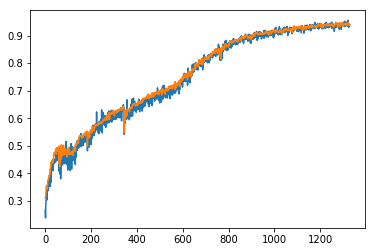

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
t_acc, valid_acc, loss_ = zip(*train_valid_accs)
plt.plot(t_acc)
plt.plot(valid_acc)
# plt.plot(loss_)

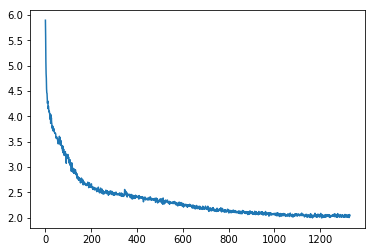

In [161]:
plt.plot(loss_)

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [162]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path) 

# Checkpoint

In [163]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
- Convert words not in the vocabulary, to the `<UNK>` word id.

In [164]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    return [vocab_to_int.get(word, vocab_to_int.get('<UNK>')) for word in sentence.lower().split()]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [165]:
translate_sentence = 'he saw a old yellow truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence], keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

Input
  Word Ids:      [170, 123, 108, 56, 214, 179, 142]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [204, 40, 250, 210, 313, 255, 326, 1]
  French Words: ['il', 'a', 'un', 'gros', 'camion', 'noir', '.', '<EOS>']


In [166]:
def translate_sentence(sentence, source_vocab_to_int):
    s2seq = sentence_to_seq(sentence, source_vocab_to_int)
    print(s2seq)
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_path + '.meta')
        loader.restore(sess, load_path)

        input_data = loaded_graph.get_tensor_by_name('input:0')
        logits = loaded_graph.get_tensor_by_name('logits:0')
        keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

        translate_logits = sess.run(logits, {input_data: [s2seq], keep_prob: 1.0})[0]

    print('Input')
    print('  Word Ids:      {}'.format([i for i in s2seq]))
    print('  English Words: {}'.format([source_int_to_vocab[i] for i in s2seq]))

    print('\nPrediction')
    print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
    print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

In [188]:
translate_sentence('india is nice during june .', source_vocab_to_int)

[99, 62, 100, 171, 57, 142]
Input
  Word Ids:      [99, 62, 100, 171, 57, 142]
  English Words: ['india', 'is', 'nice', 'during', 'june', '.']

Prediction
  Word Ids:      [109, 125, 58, 264, 46, 326, 1]
  French Words: ['inde', 'est', 'sec', 'en', 'avril', '.', '<EOS>']


In [189]:
translate_sentence('his favorite fruit is the lemon .', source_vocab_to_int)

[208, 55, 198, 62, 17, 230, 142]
Input
  Word Ids:      [208, 55, 198, 62, 17, 230, 142]
  English Words: ['his', 'favorite', 'fruit', 'is', 'the', 'lemon', '.']

Prediction
  Word Ids:      [50, 80, 200, 125, 141, 214, 326, 1]
  French Words: ['son', 'fruit', 'préféré', 'est', 'le', 'citron', '.', '<EOS>']


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  Additionally, the translations in this data set were made by Google translate, so the translations themselves aren't particularly good.  (We apologize to the French speakers out there!) Thankfully, for this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.